In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc as pm
import requests
import scipy.stats as sps

from pymc.Matplot import plot as pmplot

sns.set()

In [2]:
start_date = '2020-03-01'
end_date = '2020-08-11'

url = 'https://covidtrackerapi.bsg.ox.ac.uk/api/v2/stringency/date-range/{}/{}'.format(start_date,end_date)

r = requests.get(url,timeout=5.0)
r.status_code

200

In [3]:
keys = pd.date_range(start_date,end_date)
keys

DatetimeIndex(['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
               '2020-03-09', '2020-03-10',
               ...
               '2020-08-02', '2020-08-03', '2020-08-04', '2020-08-05',
               '2020-08-06', '2020-08-07', '2020-08-08', '2020-08-09',
               '2020-08-10', '2020-08-11'],
              dtype='datetime64[ns]', length=164, freq='D')

In [4]:
json = r.json()
data = json['data']
countries = json['countries']

In [5]:
data_list = []

for k in keys:
    date = k.date().strftime('%Y-%m-%d')
    for c in countries:
        try:
            data_list.append((date,c,data[date][c]['confirmed'],data[date][c]['deaths'],data[date][c]['stringency']))
        except KeyError:
            print ('cant find',c)


cant find AIA
cant find CYM
cant find FLK
cant find GIB
cant find AIA
cant find CYM
cant find FLK
cant find GIB
cant find AIA
cant find CYM
cant find FLK
cant find GIB
cant find AIA
cant find CYM
cant find FLK
cant find GIB
cant find AIA
cant find CYM
cant find FLK
cant find GIB
cant find AIA
cant find CYM
cant find FLK
cant find GIB
cant find AIA
cant find CYM
cant find FLK
cant find GIB
cant find AIA
cant find CYM
cant find FLK
cant find GIB
cant find AIA
cant find CYM
cant find FLK
cant find GIB
cant find AIA
cant find CYM
cant find FLK
cant find GIB
cant find AIA
cant find CYM
cant find FLK
cant find GIB
cant find AIA
cant find CYM
cant find FLK
cant find GIB
cant find AIA
cant find CYM
cant find FLK
cant find GIB
cant find AIA
cant find CYM
cant find FLK
cant find GIB
cant find AIA
cant find CYM
cant find FLK
cant find GIB
cant find AIA
cant find CYM
cant find FLK
cant find GIB
cant find AIA
cant find CYM
cant find FLK
cant find GIB
cant find AIA
cant find CYM
cant find FLK
cant f

cant find AUS
cant find AZE
cant find BDI
cant find BEL
cant find BEN
cant find BFA
cant find BGD
cant find BGR
cant find BHR
cant find BIH
cant find BLR
cant find BLZ
cant find BMU
cant find BOL
cant find BRA
cant find BRB
cant find BRN
cant find BTN
cant find BWA
cant find CAF
cant find CAN
cant find CHE
cant find CHL
cant find CHN
cant find CIV
cant find CMR
cant find COD
cant find COG
cant find COL
cant find CPV
cant find CRI
cant find CUB
cant find CYM
cant find CYP
cant find CZE
cant find DEU
cant find DJI
cant find DMA
cant find DNK
cant find DOM
cant find DZA
cant find ECU
cant find EGY
cant find ERI
cant find ESP
cant find EST
cant find ETH
cant find FIN
cant find FJI
cant find FLK
cant find FRA
cant find GAB
cant find GBR
cant find GEO
cant find GHA
cant find GIB
cant find GIN
cant find GMB
cant find GRC
cant find GRL
cant find GTM
cant find GUM
cant find GUY
cant find HKG
cant find HND
cant find HRV
cant find HTI
cant find HUN
cant find IDN
cant find IND
cant find IRL
cant f

In [6]:
df = pd.DataFrame(data_list,columns=['date','country','confirmed','dead','oxford_stringency'])
df['date'] = pd.to_datetime(df['date'])
df.set_index(['country','date'],inplace=True)
df.loc['GBR']

,confirmed,dead,oxford_stringency
date,,,
2020-03-01,42.0,0.0,11.11
2020-03-02,47.0,0.0,11.11
2020-03-03,69.0,0.0,11.11
2020-03-04,109.0,0.0,11.11
2020-03-05,164.0,0.0,11.11
...,...,...,...
2020-07-31,302301.0,45999.0,64.35
2020-08-01,303181.0,46119.0,68.06
2020-08-02,303952.0,46193.0,68.06


In [7]:
average_ox_idx = df['oxford_stringency'].groupby(level=0).mean()
average_ox_idx

country
ABW    47.937452
AFG    72.993822
AGO    68.882956
AIA    81.060909
ALB    71.375912
         ...    
VUT    59.987848
YEM    42.719182
ZAF    73.847296
ZMB    45.001761
ZWE    70.951447
Name: oxford_stringency, Length: 181, dtype: float64

In [8]:
population = pd.read_csv('world_pop.csv',sep=';',thousands=',',header=None,index_col=0)
population.columns=['pop']
population.index.name='country'
population

,pop
country,
Afghanistan,38928346
Albania,2877797
Algeria,43851044
American Samoa,55191
Andorra,77265
...,...
Wallis & Futuna,11239
Western Sahara,597339
Yemen,29825964


In [9]:
three_letter_abb = pd.read_csv('three_letter_country_abb.csv',sep=';',header=None,index_col=2)
three_letter_abb = three_letter_abb[0]
three_letter_abb.loc['GBR']

'UK'

In [10]:
df = df.reset_index(level=1)

In [11]:
df.loc['GBR']

,date,confirmed,dead,oxford_stringency
country,,,,
GBR,2020-03-01,42.0,0.0,11.11
GBR,2020-03-02,47.0,0.0,11.11
GBR,2020-03-03,69.0,0.0,11.11
GBR,2020-03-04,109.0,0.0,11.11
GBR,2020-03-05,164.0,0.0,11.11
...,...,...,...,...
GBR,2020-07-31,302301.0,45999.0,64.35
GBR,2020-08-01,303181.0,46119.0,68.06
GBR,2020-08-02,303952.0,46193.0,68.06


In [12]:
df = df.join(three_letter_abb)

In [13]:
df.rename(columns={0 : 'country'},inplace=True)

In [14]:
df = df.join(average_ox_idx,lsuffix='_current',rsuffix='_mean')

In [15]:
df

,date,confirmed,dead,oxford_stringency_current,country,oxford_stringency_mean
ABW,2020-03-01,NaN,NaN,0.00,Aruba,47.937452
ABW,2020-03-02,NaN,NaN,0.00,Aruba,47.937452
ABW,2020-03-03,NaN,NaN,0.00,Aruba,47.937452
ABW,2020-03-04,NaN,NaN,0.00,Aruba,47.937452
ABW,2020-03-05,NaN,NaN,0.00,Aruba,47.937452
...,...,...,...,...,...,...
ZWE,2020-08-02,3659.0,69.0,80.56,Zimbabwe,70.951447
ZWE,2020-08-03,3921.0,70.0,80.56,Zimbabwe,70.951447
ZWE,2020-08-04,4075.0,80.0,80.56,Zimbabwe,70.951447
ZWE,2020-08-05,4221.0,81.0,80.56,Zimbabwe,70.951447


In [16]:
foo = df.merge(population,left_on='country',right_on=population.index)
foo['dead_per_M'] = foo['dead'] / (foo['pop'] / 1e6)
foo

,date,confirmed,dead,oxford_stringency_current,country,oxford_stringency_mean,pop,dead_per_M
0,2020-03-01,NaN,NaN,0.00,Aruba,47.937452,106766,NaN
1,2020-03-02,NaN,NaN,0.00,Aruba,47.937452,106766,NaN
2,2020-03-03,NaN,NaN,0.00,Aruba,47.937452,106766,NaN
3,2020-03-04,NaN,NaN,0.00,Aruba,47.937452,106766,NaN
4,2020-03-05,NaN,NaN,0.00,Aruba,47.937452,106766,NaN
...,...,...,...,...,...,...,...,...
26542,2020-08-02,3659.0,69.0,80.56,Zimbabwe,70.951447,14862924,4.642424
26543,2020-08-03,3921.0,70.0,80.56,Zimbabwe,70.951447,14862924,4.709706
26544,2020-08-04,4075.0,80.0,80.56,Zimbabwe,70.951447,14862924,5.382521
26545,2020-08-05,4221.0,81.0,80.56,Zimbabwe,70.951447,14862924,5.449802


In [17]:
three_letter_abb.name='country'
three_letter_abb.index.name='abb'
three_letter_abb = pd.DataFrame(three_letter_abb)
three_letter_abb.columns=['country']
three_letter_abb.reset_index(inplace=True)


In [18]:
three_letter_abb

,abb,country
0,AFG,Afghanistan
1,ALB,Albania
2,DZA,Algeria
3,ASM,American Samoa
4,AND,Andorra
...,...,...
256,ESH,Western Sahara
257,YEM,Yemen
258,ZMB,Zambia
259,ZWE,Zimbabwe


In [19]:
foo = foo.merge(three_letter_abb,left_on='country',right_on='country')
foo

,date,confirmed,dead,oxford_stringency_current,country,oxford_stringency_mean,pop,dead_per_M,abb
0,2020-03-01,NaN,NaN,0.00,Aruba,47.937452,106766,NaN,ABW
1,2020-03-02,NaN,NaN,0.00,Aruba,47.937452,106766,NaN,ABW
2,2020-03-03,NaN,NaN,0.00,Aruba,47.937452,106766,NaN,ABW
3,2020-03-04,NaN,NaN,0.00,Aruba,47.937452,106766,NaN,ABW
4,2020-03-05,NaN,NaN,0.00,Aruba,47.937452,106766,NaN,ABW
...,...,...,...,...,...,...,...,...,...
26542,2020-08-02,3659.0,69.0,80.56,Zimbabwe,70.951447,14862924,4.642424,ZWE
26543,2020-08-03,3921.0,70.0,80.56,Zimbabwe,70.951447,14862924,4.709706,ZWE
26544,2020-08-04,4075.0,80.0,80.56,Zimbabwe,70.951447,14862924,5.382521,ZWE
26545,2020-08-05,4221.0,81.0,80.56,Zimbabwe,70.951447,14862924,5.449802,ZWE


In [20]:
gbr = foo.loc[foo['abb'] == 'GBR']
gbr

,date,confirmed,dead,oxford_stringency_current,country,oxford_stringency_mean,pop,dead_per_M,abb
8935,2020-03-01,42.0,0.0,11.11,UK,63.235096,67886011,0.000000,GBR
8936,2020-03-02,47.0,0.0,11.11,UK,63.235096,67886011,0.000000,GBR
8937,2020-03-03,69.0,0.0,11.11,UK,63.235096,67886011,0.000000,GBR
8938,2020-03-04,109.0,0.0,11.11,UK,63.235096,67886011,0.000000,GBR
8939,2020-03-05,164.0,0.0,11.11,UK,63.235096,67886011,0.000000,GBR
...,...,...,...,...,...,...,...,...,...
9087,2020-07-31,302301.0,45999.0,64.35,UK,63.235096,67886011,677.591735,GBR
9088,2020-08-01,303181.0,46119.0,68.06,UK,63.235096,67886011,679.359404,GBR
9089,2020-08-02,303952.0,46193.0,68.06,UK,63.235096,67886011,680.449467,GBR
9090,2020-08-03,304695.0,46201.0,68.06,UK,63.235096,67886011,680.567312,GBR


In [21]:
last_data_date = gbr['date'].iloc[-1]
last_data_date

Timestamp('2020-08-06 00:00:00')

In [22]:
last_days = foo.loc[foo['date'] == last_data_date]
drop = ['San Marino','Andorra']

mask = last_days['country'].isin(drop)
last_days = last_days[~mask]

#last_days = last_days.merge(three_letter_abb,left_on='country',right_on='country')

last_days['conf_per_M'] = last_days['confirmed'] / (last_days['pop'] / 1e6)

### MASK ###
mask2 = last_days['dead_per_M'] > 10
############

last_days = last_days[mask2]
last_days['dead_per_M_log'] = np.log10(last_days['dead_per_M'])

last_days

,date,confirmed,dead,oxford_stringency_current,country,oxford_stringency_mean,pop,dead_per_M,abb,conf_per_M,dead_per_M_log
156,2020-08-06,171.0,3.0,32.41,Aruba,47.937452,106766,28.098833,ABW,1601.633479,1.448688
313,2020-08-06,36896.0,1298.0,78.70,Afghanistan,72.993822,38928346,33.343312,AFG,947.792644,1.523009
717,2020-08-06,5889.0,182.0,59.26,Albania,71.375912,2877797,63.242821,ALB,2046.356988,1.801011
1028,2020-08-06,61860.0,355.0,50.00,United Arab Emirates,65.684605,9890402,35.893384,ARE,6254.548602,1.555014
1187,2020-08-06,213522.0,4009.0,88.89,Argentina,84.294025,45195774,88.702984,ARG,4724.379762,1.947938
...,...,...,...,...,...,...,...,...,...,...,...
25275,2020-08-06,75490.0,1788.0,54.17,Ukraine,66.373312,43733762,40.883746,UKR,1726.126373,1.611551
25434,2020-08-06,1309.0,37.0,22.22,Uruguay,47.879874,3473730,10.651375,URY,376.828366,1.027406
25593,2020-08-06,4823891.0,158256.0,68.98,US,66.205660,331002651,478.110974,USA,14573.572101,2.679529
26069,2020-08-06,1764.0,508.0,31.48,Yemen,42.719182,29825964,17.032140,YEM,59.143101,1.231269


In [23]:
last_days.sort_values('oxford_stringency_mean',ascending=True).head(50)



,date,confirmed,dead,oxford_stringency_current,country,oxford_stringency_mean,pop,dead_per_M,abb,conf_per_M,dead_per_M_log
17861,2020-08-06,3902.0,123.0,16.67,Nicaragua,11.931761,6624554,18.567288,NIC,589.020785,1.268748
3096,2020-08-06,68376.0,577.0,11.11,Belarus,11.977452,9449323,61.062576,BLR,7236.073949,1.785775
23070,2020-08-06,81540.0,5760.0,37.04,Sweden,38.075786,10099265,570.338535,SWE,8073.854880,2.756133
12323,2020-08-06,1926.0,10.0,39.81,Iceland,40.395064,341243,29.304630,ISL,5644.071820,1.466936
26069,2020-08-06,1764.0,508.0,31.48,Yemen,42.719182,29825964,17.032140,YEM,59.143101,1.231269
8457,2020-08-06,7512.0,331.0,37.96,Finland,45.063203,5540720,59.739528,FIN,1355.780476,1.776262
8145,2020-08-06,2113.0,63.0,27.78,Estonia,45.230252,1326535,47.492151,EST,1592.871654,1.676622
15021,2020-08-06,7007.0,118.0,22.22,Luxembourg,47.488805,625978,188.505027,LUX,11193.684123,2.275323
25434,2020-08-06,1309.0,37.0,22.22,Uruguay,47.879874,3473730,10.651375,URY,376.828366,1.027406
156,2020-08-06,171.0,3.0,32.41,Aruba,47.937452,106766,28.098833,ABW,1601.633479,1.448688


In [24]:
last_days.shape

(96, 11)

In [25]:
x = last_days['oxford_stringency_mean']

y_param = 'dead_per_M'

if y_param == 'dead_per_M':
    beta_mean = 0
    beta_std = 1
    alpha_low = -500
    alpha_high = 500
    obs_sigma_high = 500
    
else:
    beta_mean = 0
    beta_std = 1000
    alpha_low = -4000
    alpha_high = 4000
    obs_sigma_high = 10000

alpha = pm.Uniform('alpha',alpha_low,alpha_high)
#beta = pm.Uniform('beta',beta_low,beta_high)
beta = pm.Normal('beta',beta_mean, 1 / beta_std **2)
obs_sigma = pm.Uniform('obs_sigma',0,obs_sigma_high)

@pm.deterministic
def linreq(x=x,alpha=alpha,beta=beta):
    return alpha + x * beta

obs = pm.Normal('obs',mu = linreq,tau = 1 / obs_sigma ** 2,observed = True,value = last_days[y_param])

model = pm.Model([alpha,beta,linreq,obs])

map_ = pm.MAP(model)
map_.fit()

mcmc = pm.MCMC(model)

sample = mcmc.sample(50000,20000,3)

 [-----------------100%-----------------] 50000 of 50000 complete in 65.9 sec

Plotting beta_post
Plotting alpha_post
Plotting obs_sigma_post


,beta_post,alpha_post,obs_sigma_post
count,10000.000000,10000.000000,10000.000000
mean,0.498282,102.295541,173.798391
std,0.800773,54.998052,12.778540
min,-2.430621,-108.188783,132.866095
25%,-0.009434,68.448631,164.870552
50%,0.505342,101.334262,173.031067
75%,0.997425,136.634540,181.803784
max,3.541007,328.717138,239.980984


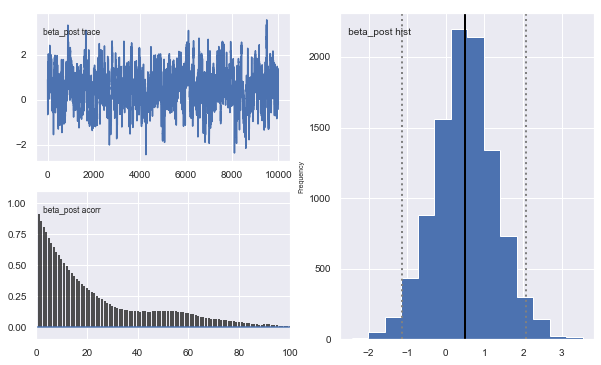

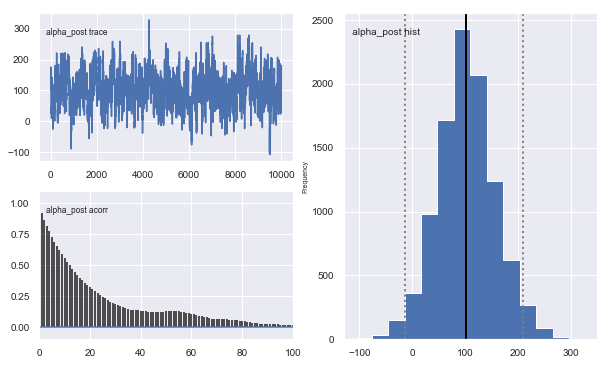

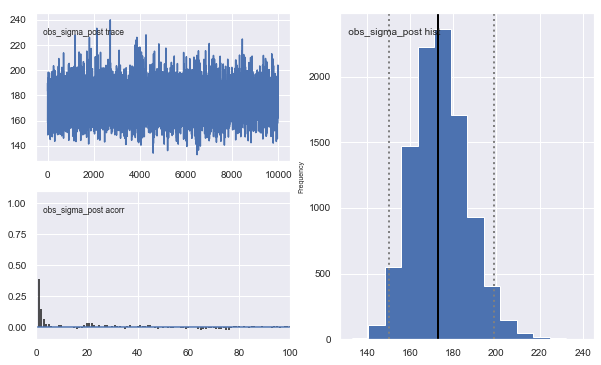

In [26]:
beta_post = mcmc.trace('beta')[:]
alpha_post = mcmc.trace('alpha')[:]
obs_sigma_post = mcmc.trace('obs_sigma')[:]

pmplot(beta_post,'beta_post')
pmplot(alpha_post,'alpha_post')
pmplot(obs_sigma_post,'obs_sigma_post')

result = pd.DataFrame({'beta_post' : beta_post,
                      'alpha_post' : alpha_post,
                      'obs_sigma_post' : obs_sigma_post})

result.describe()

In [27]:
beta_ci = np.percentile(result['beta_post'],[5.5,94.5])
alpha_ci = np.percentile(result['alpha_post'],[5.5,94.5])

In [28]:
mean_req = np.array([x * result['beta_post'].mean() + result['alpha_post'].mean() for x in range(0,101)])

slope,intercept,_,_,_ = sps.linregress(last_days['oxford_stringency_mean'],last_days[y_param])

least_squares = np.array([x * slope + intercept for x in range(0,101)])

In [29]:
X = np.linspace(0,100,1000)
rows = np.random.choice(result.index,replace=True,size=len(X))
beta_samples = result['beta_post'][rows]
alpha_samples = result['alpha_post'][rows]

lines = np.array([X[i] * beta_samples + alpha_samples for i in range(len(X))])

samples = np.array([pm.rnormal(X[i] * result.beta_post[rows] + result.alpha_post[rows],
                                      1 / result.obs_sigma_post[rows] ** 2,size=len(X)) for i in range(len(X))])

high,low = np.percentile(samples,[5.5,94.5],axis=1)




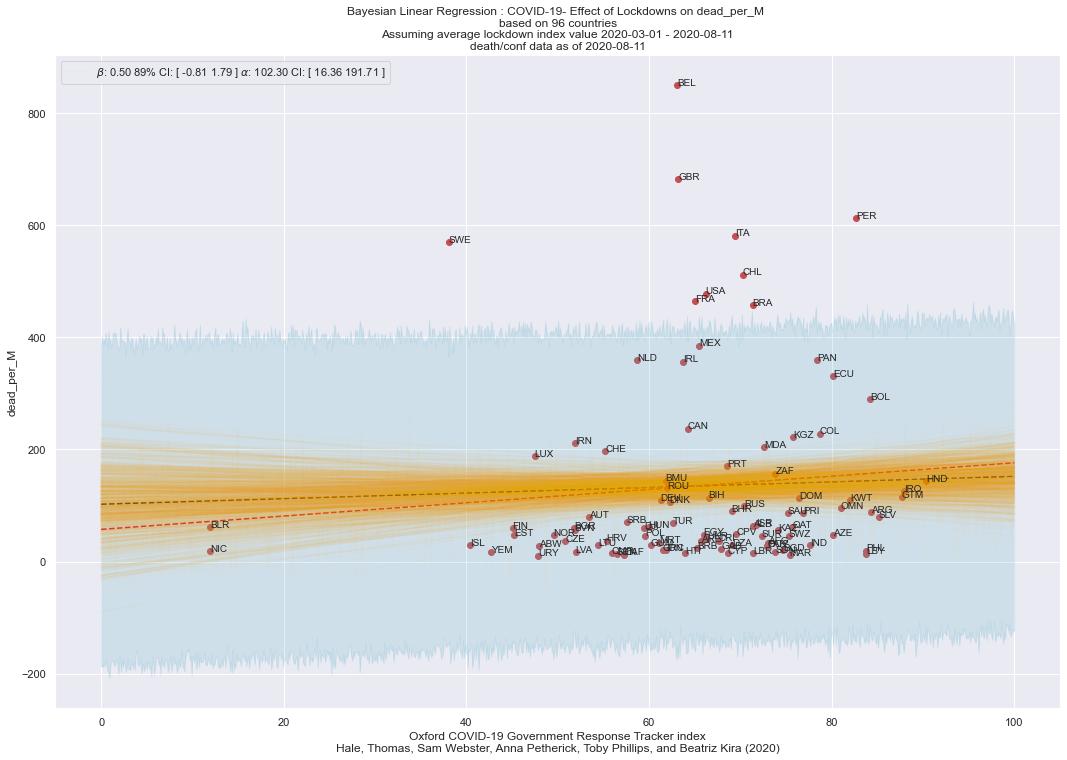

In [30]:
plt.figure(figsize=(18,12))
plt.title('Bayesian Linear Regression : COVID-19'\
          '- Effect of Lockdowns on {} \n'.format(y_param)+\
          'based on {} countries\n'.format(len(last_days))+\
          'Assuming average lockdown index value {} - {}\n'.format(start_date,end_date)+\
         'death/conf data as of {}'.format(end_date))

plt.scatter(last_days['oxford_stringency_mean'],last_days[y_param],color='r')
plt.ylabel(y_param)
plt.xlabel('Oxford COVID-19 Government Response Tracker index\nHale, Thomas, Sam Webster, Anna Petherick, Toby Phillips, and Beatriz Kira (2020)')

plt.plot(range(0,101),mean_req,ls='dashed',color='k')
plt.plot(range(0,101),least_squares,ls='dashed',color='crimson')

plt.fill_between(X,high,low,color='c',alpha=0.2)

countries_of_interest = ['SWE','GBR','BEL','ESP','ITA','PER','FRA',
                         'USA','DNK','FIN','NOR','BRA','CHL','QAT','BHR',
                        'HNT','GTM','NIC','JPN','ISL','ARG','NLD','DEU','ZAF','HND','IRQ']

for i,p in enumerate(last_days['oxford_stringency_mean']):
    #if last_days.iloc[i]['abb'] in countries_of_interest:
    plt.text(last_days.iloc[i]['oxford_stringency_mean'],last_days.iloc[i][y_param],last_days.iloc[i]['abb'])

plt.plot(X,lines[0,:],
         color='orange',
         alpha=0.03,
         label=r'$\beta$: {:.2f} 89% CI: [ {:.2f} {:.2f} ] $\alpha$: {:.2f} CI: [ {:.2f} {:.2f} ]'.format(
         result.beta_post.mean(),beta_ci[0],beta_ci[1],result.alpha_post.mean(),alpha_ci[0],alpha_ci[1]))

_=plt.plot(X,lines,color='orange',alpha=0.03)

plt.legend(loc='upper left')

plt.savefig('lockdown_index_{}.jpg'.format(y_param),format='jpg',dpi=400)

In [31]:
foo.dropna(inplace=True)

In [32]:
countries = foo.groupby('country')
some_countries = ['Sweden','Belgium','UK','South Africa','Germany','US',
                  'Denmark','Australia','Italy','France','Argentina','Brazil','Chile','Peru']

colors = ['black','grey','lightcoral','mistyrose','tan','gold','crimson','yellow',
         'deepskyblue','royalblue','orangered','lime','aqua','darkmagenta']



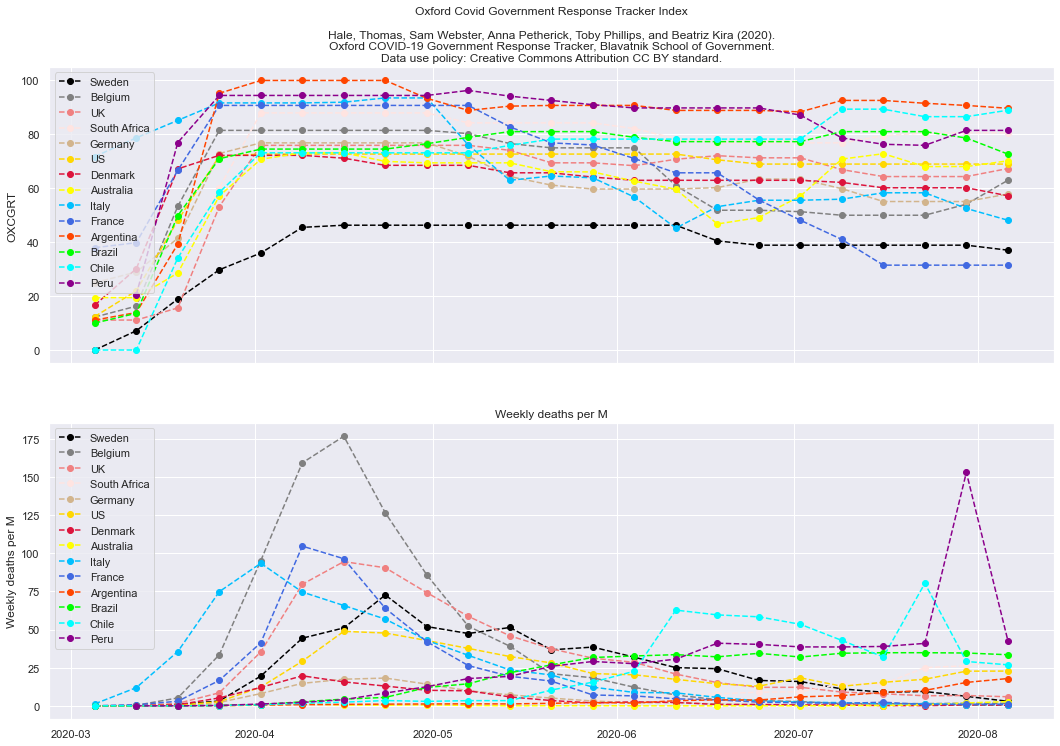

In [33]:
from datetime import datetime

weeklies = dict()

fig,ax = plt.subplots(2,1,sharex=True,figsize=(18,12))


for i,c in enumerate(some_countries):
    country = (countries.get_group(c)).copy()
    country.set_index('date',inplace=True)
    country['dead_inc'] = country['dead'] - country['dead'].shift()
    country['dead_inc_per_M'] = country['dead_inc'] / (country['pop'] / 1e6)
    
    resample_period = ['W-MON','W-TUE','W-WED','W-THU','W-FRI','W-SAT','W-SUN']
    
    #today = datetime.today().weekday()
    last_data_day = last_data_date.weekday()

    #yesterday = lambda i : resample_period[i % 7 -1] if i != 0 else resample_period[6]
    period = resample_period[last_data_day]
    
    weekly = country.resample(period).agg({'dead_inc_per_M' : np.sum, 'dead_per_M' :np.sum,
                                           'oxford_stringency_current' : np.mean})
    
    weeklies[c] = weekly
        
    ax[1].plot(weekly.index,weekly['dead_inc_per_M'],'o--',label=c,color=colors[i])
    ax[0].plot(weekly.index,weekly['oxford_stringency_current'],'o--',label=c,color=colors[i])
 
citation = '\nHale, Thomas, Sam Webster, Anna Petherick, Toby Phillips, and Beatriz Kira (2020).\nOxford COVID-19 Government Response Tracker, Blavatnik School of Government.\nData use policy: Creative Commons Attribution CC BY standard.'
ax[0].legend(loc='upper left')
ax[0].set_title('Oxford Covid Government Response Tracker Index\n' + citation)
ax[0].set_ylabel('OXCGRT')
#ax[0].set_yscale('log')
ax[1].legend(loc='upper left')
ax[1].set_title('Weekly deaths per M')
ax[1].set_ylabel('Weekly deaths per M')
#ax[1].set_yscale('log')
plt.savefig('oxcgrt_country_plot.jpg',format='jpg',dpi=400)

In [34]:
steps = 100000
burn = 40000
thin = 3

dist_size = (steps - burn) // thin

def inference(x,y):
    
    beta_mean = 0
    beta_std = 10
    alpha_low = -500
    alpha_high = 500
    obs_sigma_high = 1000

    alpha = pm.Uniform('alpha',alpha_low,alpha_high)
    beta = pm.Normal('beta',beta_mean, 1 / beta_std **2)
    obs_sigma = pm.Uniform('obs_sigma',0,obs_sigma_high)

    @pm.deterministic
    def linreq(x=x,alpha=alpha,beta=beta):
        return alpha + x * beta

    obs = pm.Normal('obs',mu = linreq,tau = 1 / obs_sigma ** 2,observed = True,value = y)

    model = pm.Model([alpha,beta,linreq,obs])

    map_ = pm.MAP(model)
    map_.fit()

    mcmc = pm.MCMC(model)

    sample = mcmc.sample(steps,burn,thin)   
    
    beta_post = mcmc.trace('beta')[:]
    alpha_post = mcmc.trace('alpha')[:]
    obs_sigma_post = mcmc.trace('obs_sigma')[:]

    pmplot(beta_post,'beta_post')
    pmplot(alpha_post,'alpha_post')
    pmplot(obs_sigma_post,'obs_sigma_post')

    result = pd.DataFrame({'beta_post' : beta_post,
                          'alpha_post' : alpha_post,
                          'obs_sigma_post' : obs_sigma_post})

    return result


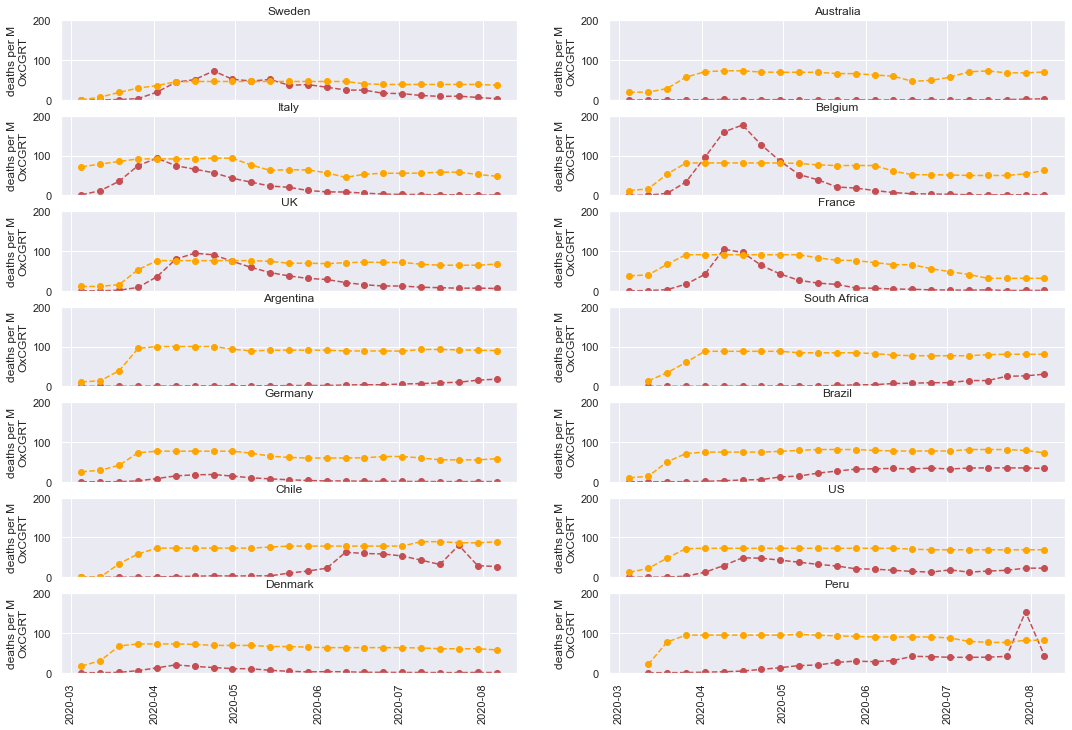

In [35]:
import scipy.stats as sps

weeklies_df = pd.DataFrame()


fig,axes = plt.subplots(7,2,sharex=True,figsize=(18,12))

for i,k in enumerate(weeklies.keys()):
        
    weeklies[k]['country'] = k
        
    weeklies_df = pd.concat([weeklies_df,weeklies[k]])
    
    
    axes[i % 7,i % 2].plot(weeklies[k].index,weeklies[k]['dead_inc_per_M'],'o--',label='weekly deaths per M',
                           color='r')
    axes[i % 7,i % 2].plot(weeklies[k].index,weeklies[k]['oxford_stringency_current'],'o--',label='weekly deaths per M',
                           color='orange')
    axes[i % 7,i % 2].tick_params('x',rotation=90)
    axes[i % 7,i % 2].set_title('{}'.format(k))
    axes[i % 7, i % 2].set_ylabel('deaths per M\nOxCGRT')
    axes[i % 7, i % 2].set_ylim([0,200])
    #axes[i % 7, i % 2].set_yscale('log')
    
plt.savefig('oxcgrt_14.jpg',format='jpg',dpi=400)

 [-----------------100%-----------------] 100000 of 100000 complete in 141.1 secPlotting beta_post
Plotting alpha_post
Plotting obs_sigma_post
 [-----------------100%-----------------] 100000 of 100000 complete in 142.8 secPlotting beta_post
Plotting alpha_post
Plotting obs_sigma_post
 [-----------------100%-----------------] 100000 of 100000 complete in 148.9 secPlotting beta_post
Plotting alpha_post
Plotting obs_sigma_post
 [-----------------100%-----------------] 100000 of 100000 complete in 131.0 secPlotting beta_post
Plotting alpha_post
Plotting obs_sigma_post
 [-----------------100%-----------------] 100000 of 100000 complete in 145.7 secPlotting beta_post
Plotting alpha_post
Plotting obs_sigma_post
 [-----------------100%-----------------] 100000 of 100000 complete in 165.6 secPlotting beta_post
Plotting alpha_post
Plotting obs_sigma_post
 [-----------------100%-----------------] 100000 of 100000 complete in 176.1 secPlotting beta_post
Plotting alpha_post
Plotting obs_sigma_post

/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


 [-----------------100%-----------------] 100000 of 100000 complete in 163.5 secPlotting beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting obs_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


 [-----------------100%-----------------] 100000 of 100000 complete in 166.0 secPlotting beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting obs_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


 [-----------------100%-----------------] 100000 of 100000 complete in 359.0 secPlotting beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting obs_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


 [-----------------100%-----------------] 100000 of 100000 complete in 159.6 secPlotting beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting obs_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


 [-----------------100%-----------------] 100000 of 100000 complete in 164.7 secPlotting beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting obs_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


 [-----------------100%-----------------] 100000 of 100000 complete in 159.5 secPlotting beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting obs_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


 [-----------------100%-----------------] 100000 of 100000 complete in 154.5 secPlotting beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting obs_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


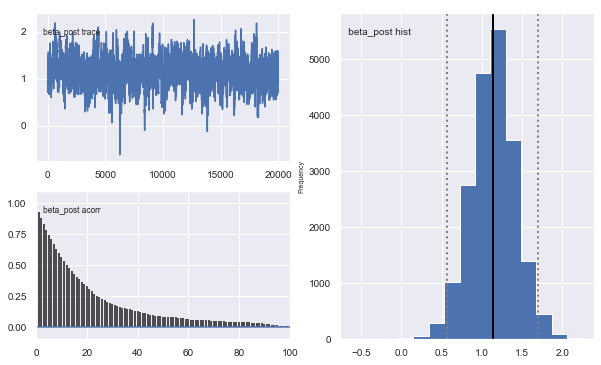

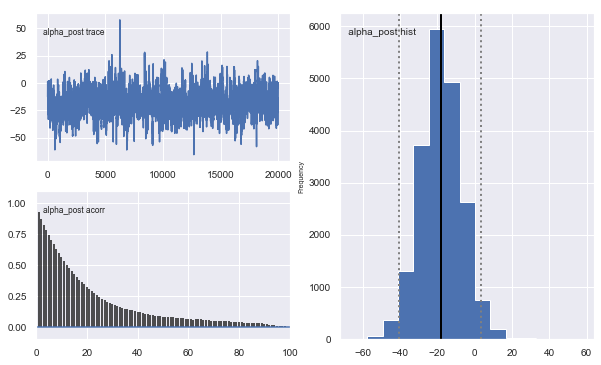

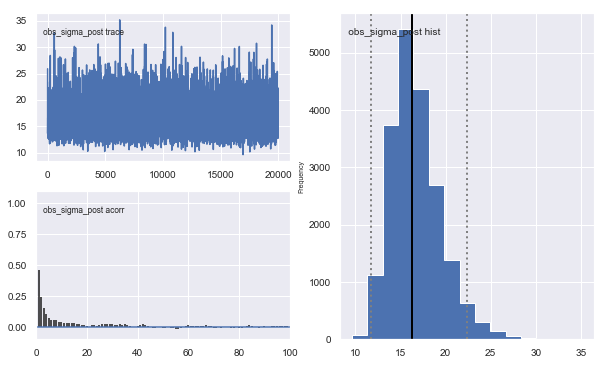

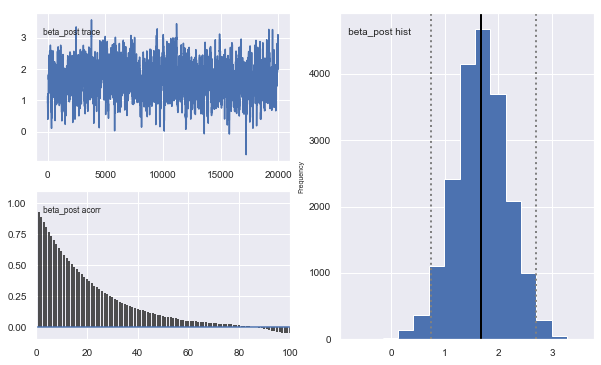

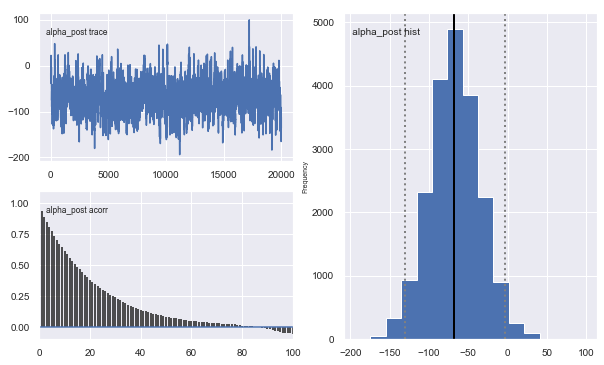

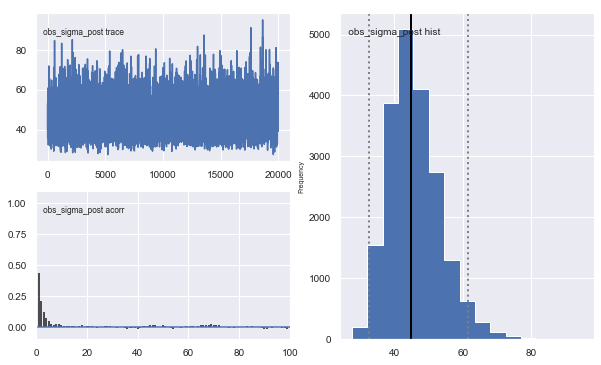

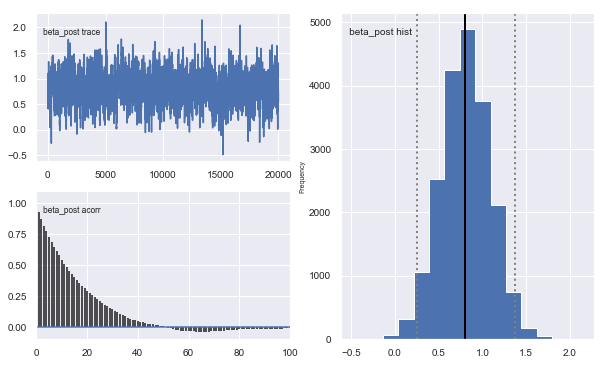

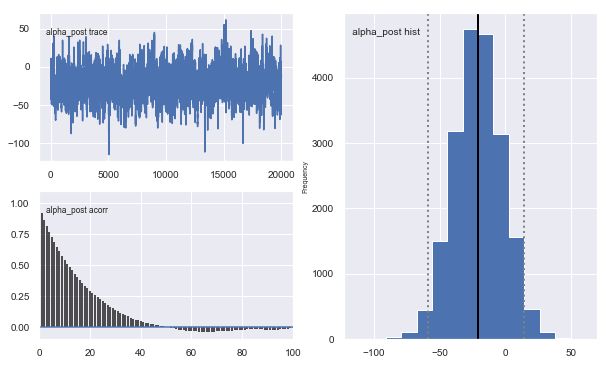

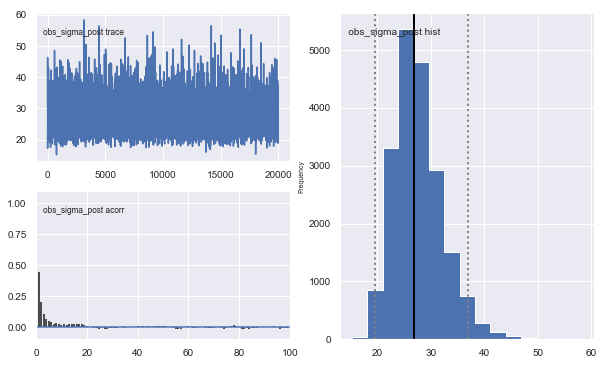

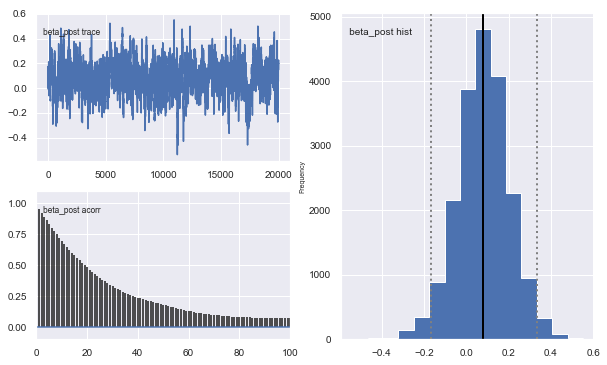

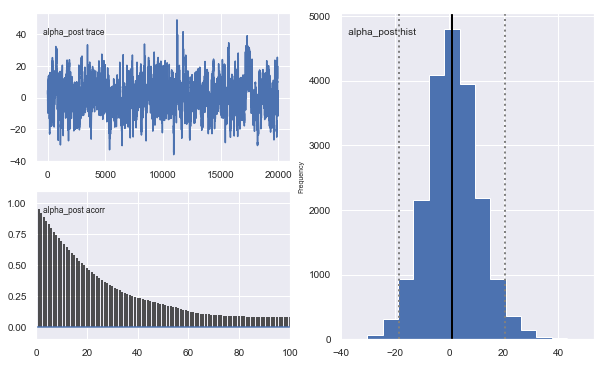

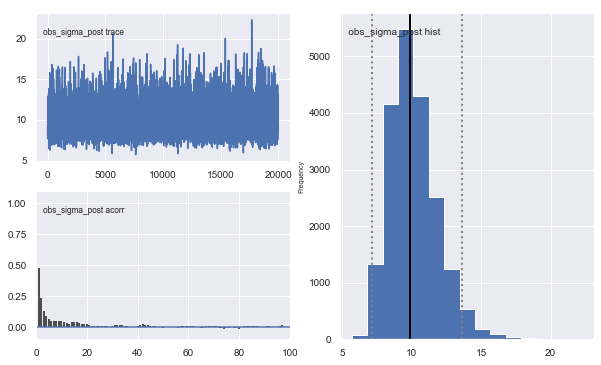

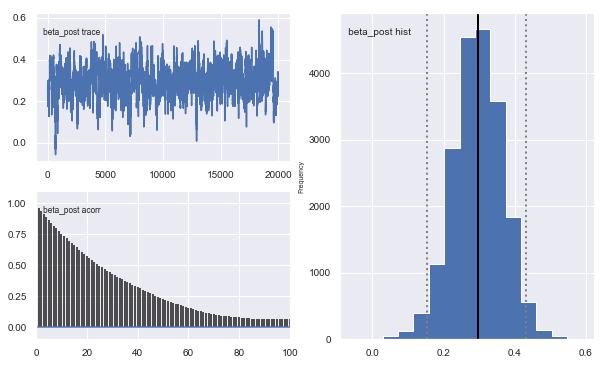

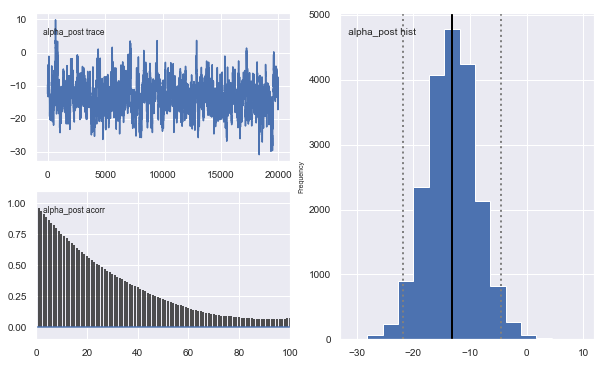

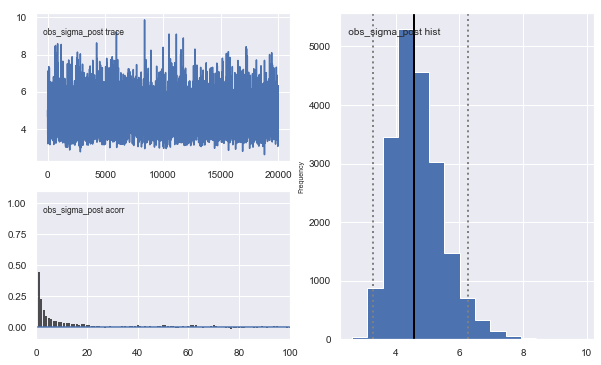

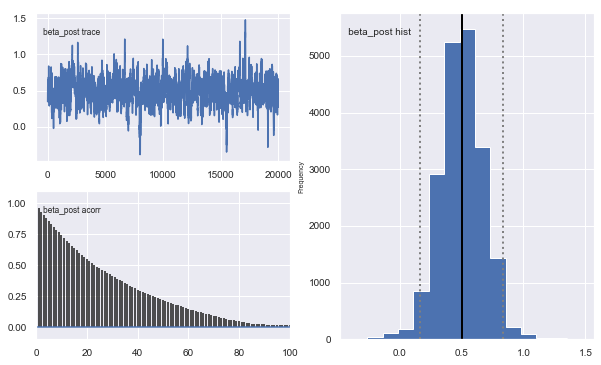

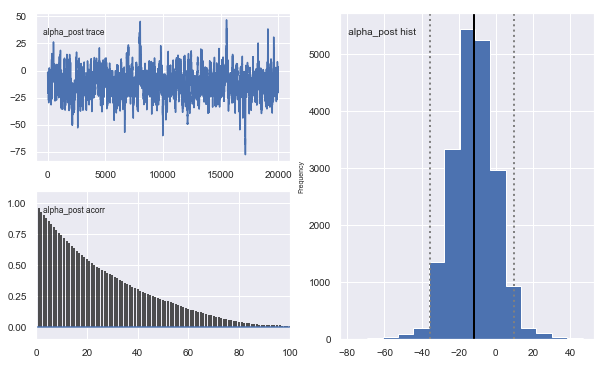

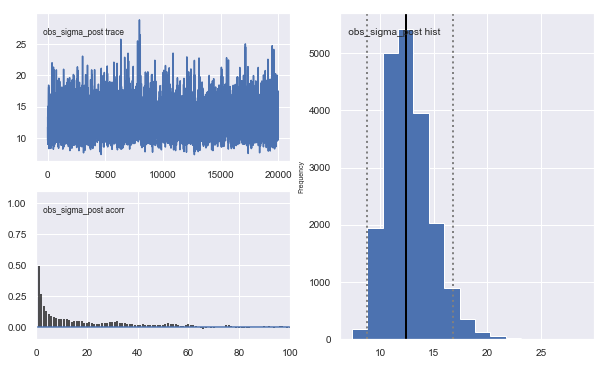

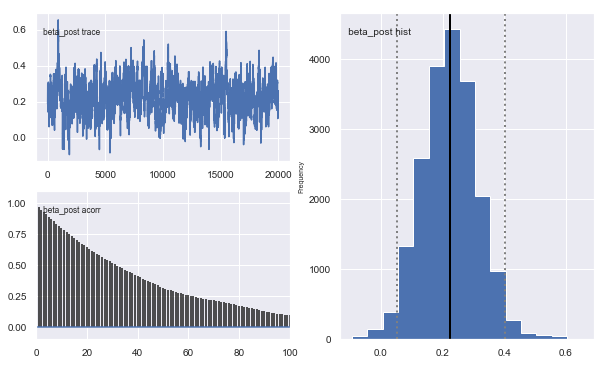

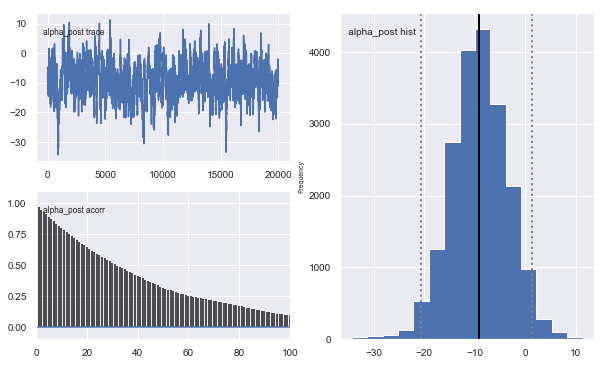

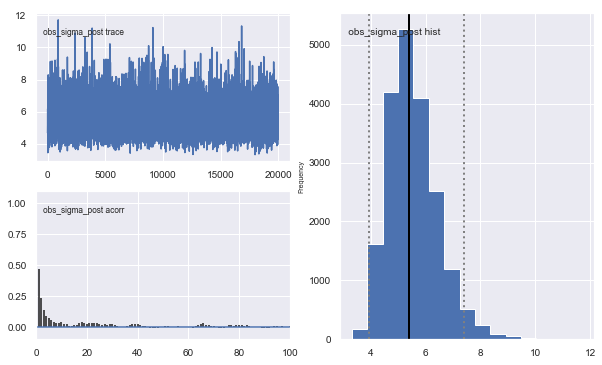

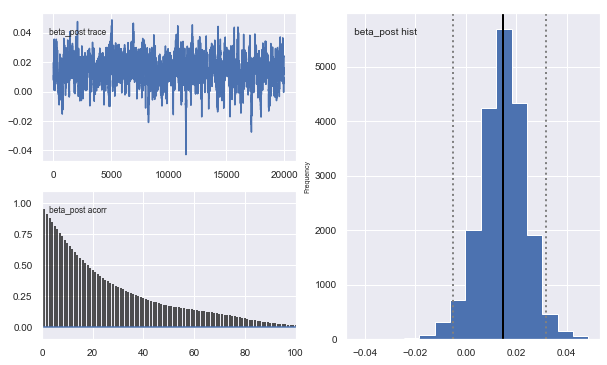

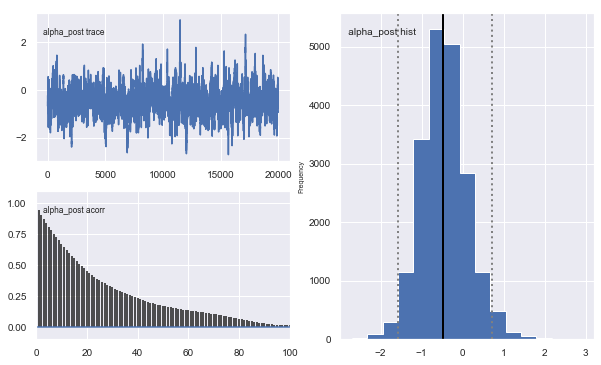

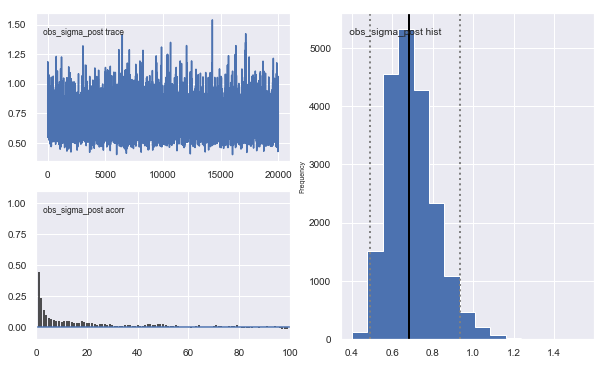

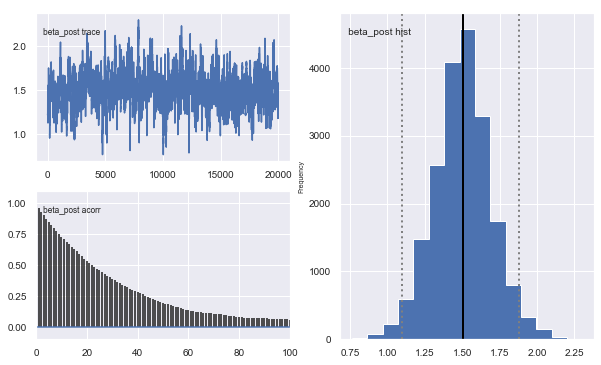

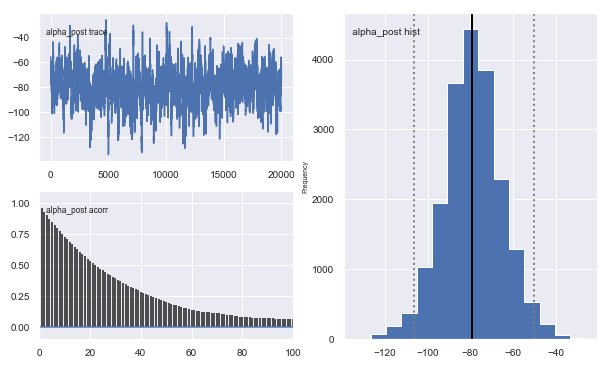

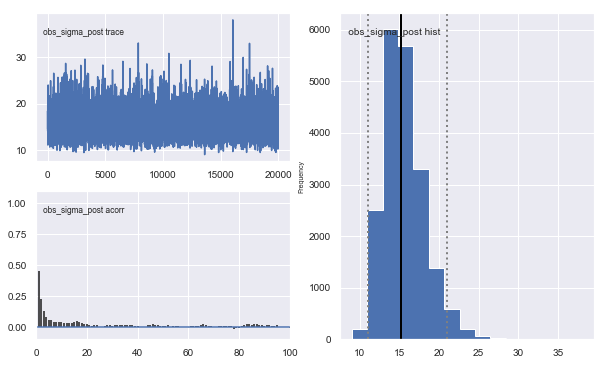

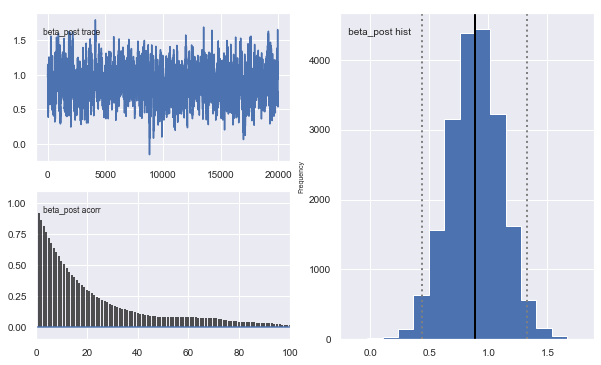

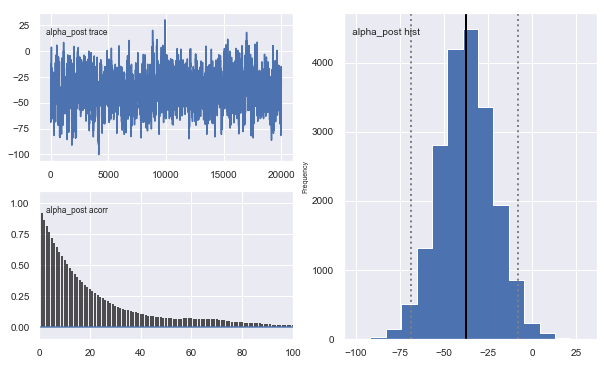

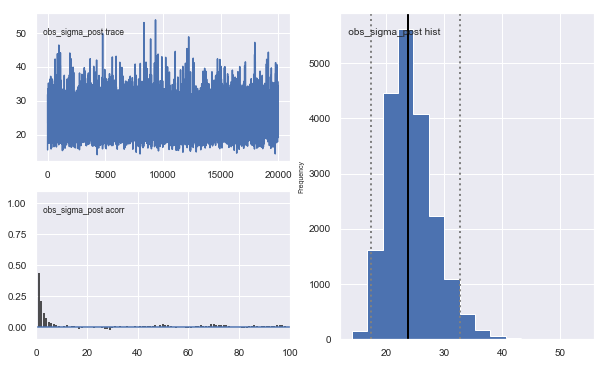

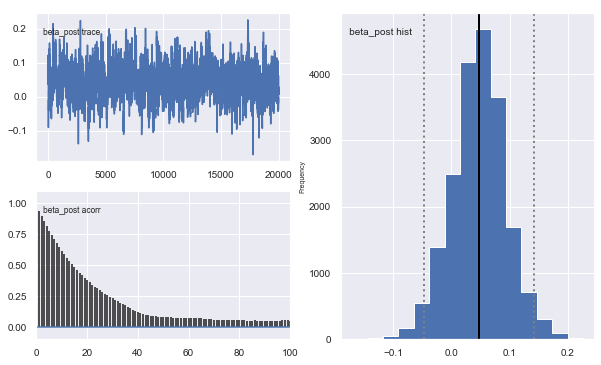

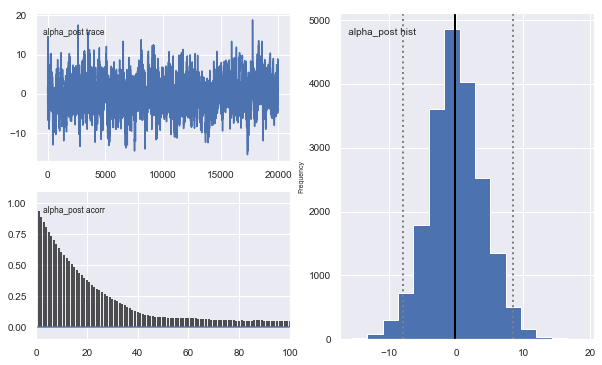

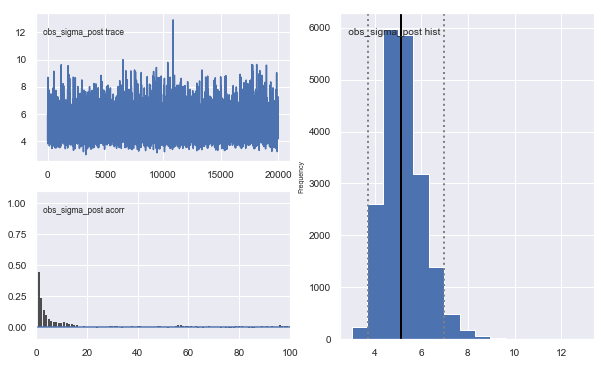

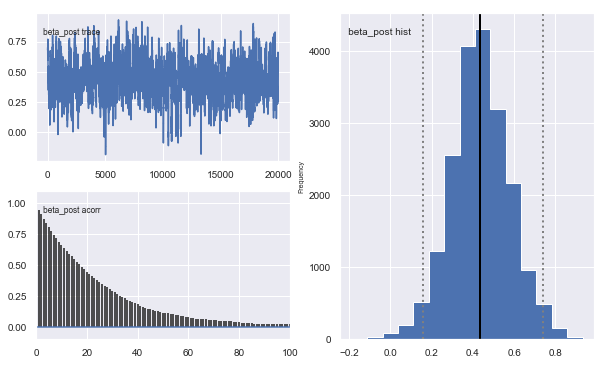

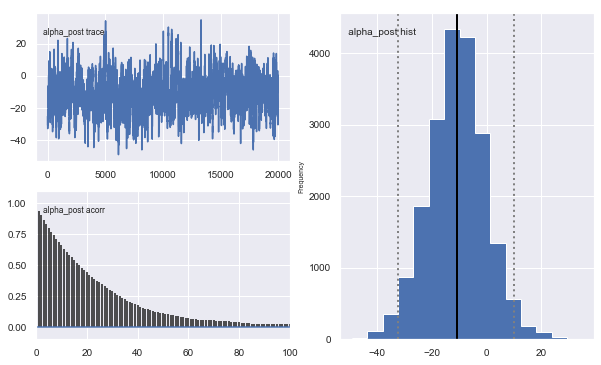

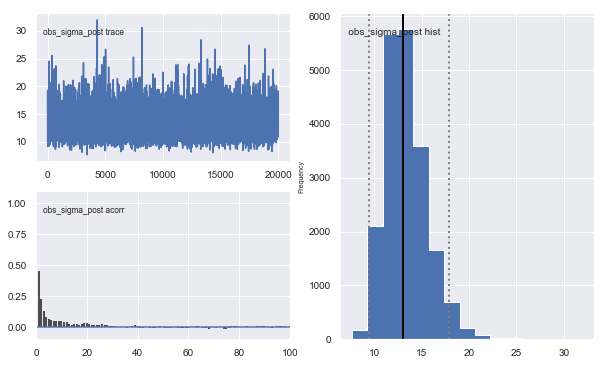

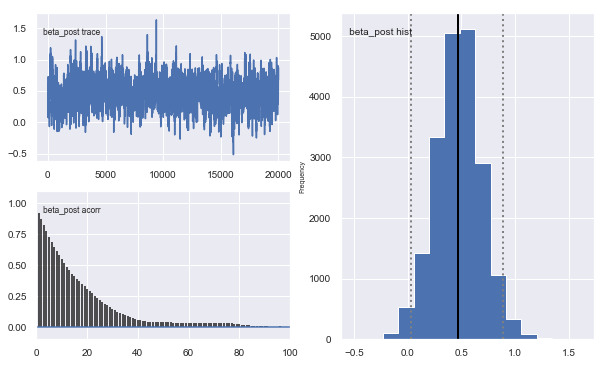

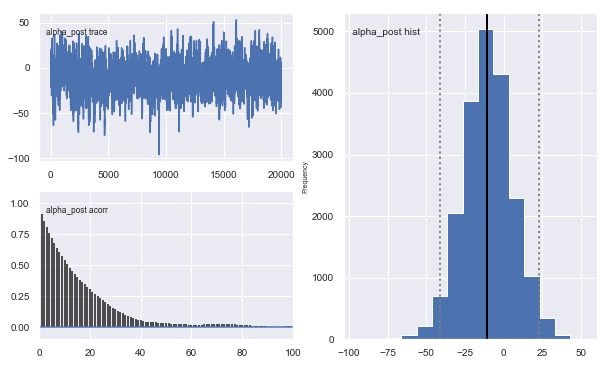

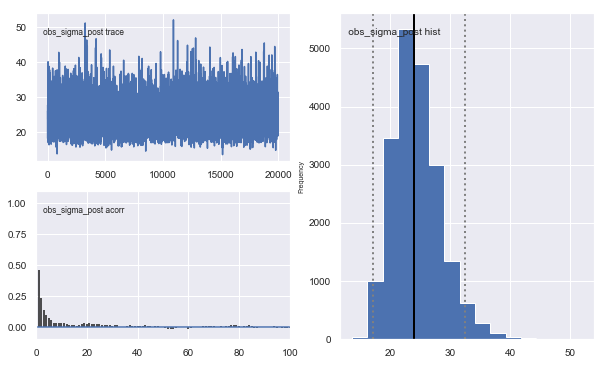

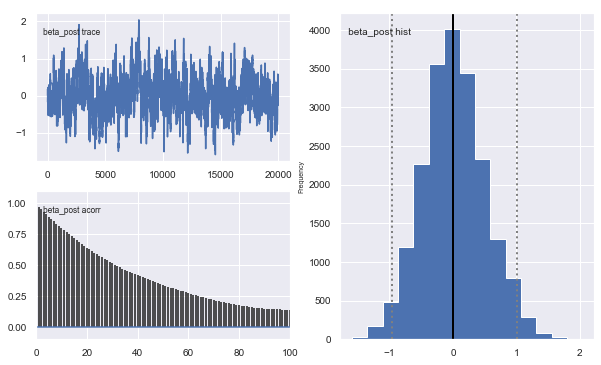

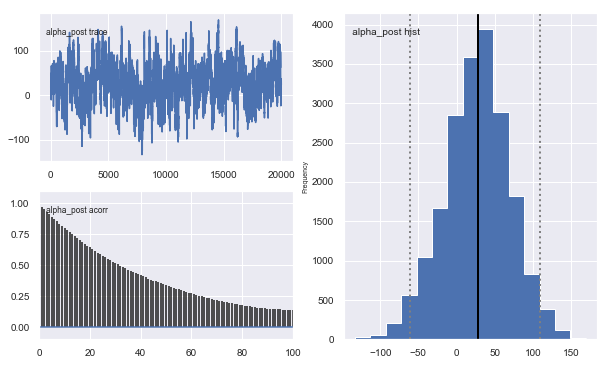

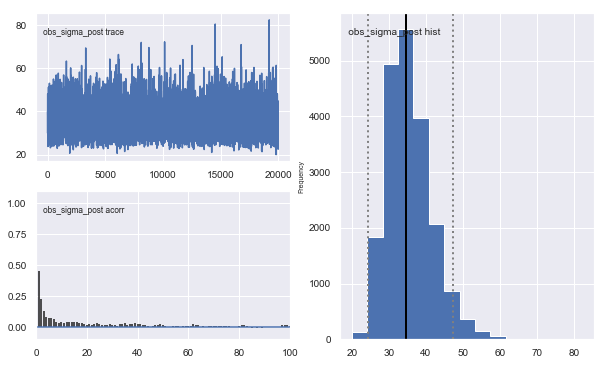

In [36]:
results = dict()

for i,k in enumerate(weeklies.keys()):

    results[k] = inference(weeklies[k]['oxford_stringency_current'],weeklies[k]['dead_inc_per_M'])



In [37]:


print (results['Argentina'].describe())
results['Sweden'].describe()


          beta_post    alpha_post  obs_sigma_post
count  20000.000000  20000.000000    20000.000000
mean       0.046488     -0.020062        5.224852
std        0.046802      4.058077        0.876628
min       -0.169948    -15.520453        3.020315
25%        0.017149     -2.619243        4.596541
50%        0.047751     -0.117996        5.125007
75%        0.076094      2.549054        5.711928
max        0.225682     18.873033       12.921434


,beta_post,alpha_post,obs_sigma_post
count,20000.000000,20000.000000,20000.000000
mean,1.134461,-17.934606,16.723662
std,0.286112,11.342439,2.825480
min,-0.615382,-65.671893,9.613516
25%,0.953477,-25.208183,14.748174
50%,1.141658,-18.130644,16.306474
75%,1.316829,-10.751125,18.277341
max,2.252297,57.818625,35.191859


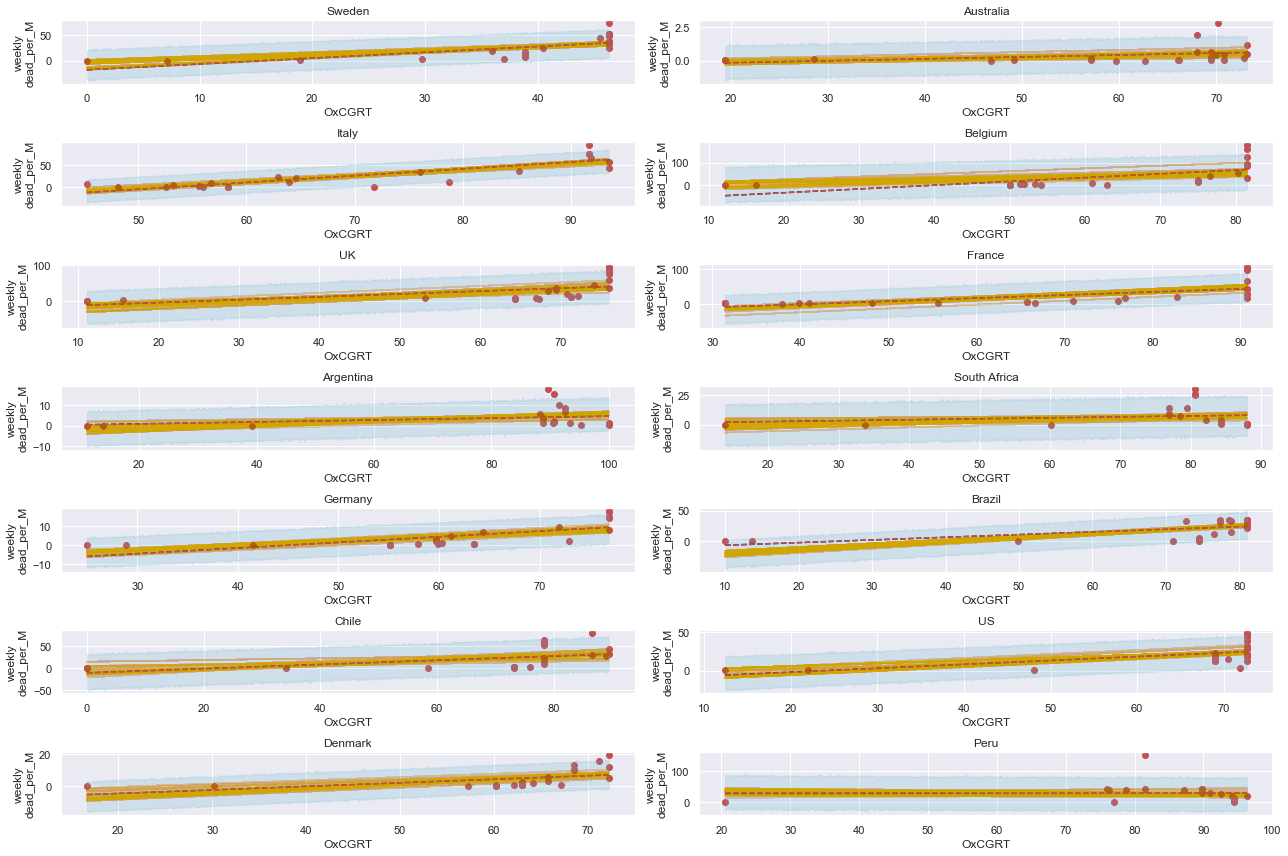

In [38]:
fig,axes = plt.subplots(7,2,figsize=(18,12))

nr_samples = 1000

for i,k in enumerate(weeklies.keys()):

    axes[i % 7,i %2].scatter(weeklies[k]['oxford_stringency_current'],weeklies[k]['dead_inc_per_M'],color='r')

    slope,intercept,_,_,_ = sps.linregress(weeklies[k]['oxford_stringency_current'],
                                           weeklies[k]['dead_inc_per_M'])

    X = np.linspace(weeklies[k]['oxford_stringency_current'].min(),
                    weeklies[k]['oxford_stringency_current'].max(),nr_samples)
        
    #X = np.linspace(0,100,nr_samples) # for computing samples, this must concur with nr of sample rows
    
    alpha_mean = results[k].alpha_post.mean()
    beta_mean = results[k].beta_post.mean()
    
    axes[i % 7, i %2].plot(X,X*beta_mean + alpha_mean,'--',color='k')
    
    rows = np.random.choice(range(len(weeklies[k].index)),replace=True,size=nr_samples)
    
    lines = [X[i] * results[k].iloc[rows].beta_post + results[k].iloc[rows].alpha_post for i in range(len(X))]
    
    samples = np.array([pm.rnormal(X[i] * results[k].iloc[rows].beta_post + results[k].iloc[rows].alpha_post,
                                      1 / results[k].iloc[rows].obs_sigma_post ** 2,size=len(X)) for i in range(len(X))])

    high,low = np.percentile(samples,[5.5,94.5],axis=1)
    
    axes[i % 7, i % 2].plot(X,lines,color='orange',alpha=0.01)
    
    least_squares = X * slope + intercept

    axes[i % 7, i % 2].plot(X,least_squares,'--',color='r')
    
    axes[i % 7, i % 2].fill_between(X,high,low,color='c',alpha=0.2)

    
    axes[i % 7, i % 2].set_title(k)
    axes[i % 7, i % 2].set_ylabel('weekly\ndead_per_M')
    axes[i % 7, i % 2].set_xlabel('OxCGRT')
    #axes[i % 7,i % 2].set_ylim([0,150])
    
plt.tight_layout()
plt.savefig('OxCGRT_regression_14.jpg',format='jpg',dpi=400)

In [39]:
swe_weekly = weeklies_df.loc[weeklies_df['country'] == 'Sweden']
bel_weekly = weeklies_df.loc[weeklies_df['country'] == 'Belgium']
arg_weekly = weeklies_df.loc[weeklies_df['country'] == 'Argentina']

In [40]:
swe_weekly

,dead_inc_per_M,dead_per_M,oxford_stringency_current,country
date,,,,
2020-03-05,0.000000,0.000000,0.000000,Sweden
2020-03-12,0.099017,0.099017,7.142857,Sweden
2020-03-19,0.891154,3.069530,18.917143,Sweden
2020-03-26,3.168547,16.832908,29.760000,Sweden
2020-04-02,19.506370,92.580995,35.981429,Sweden
2020-04-09,44.359664,311.309783,45.505714,Sweden
2020-04-16,51.092827,653.908973,46.300000,Sweden
2020-04-23,72.678556,1095.723303,46.300000,Sweden
2020-04-30,51.983981,1549.617720,46.300000,Sweden


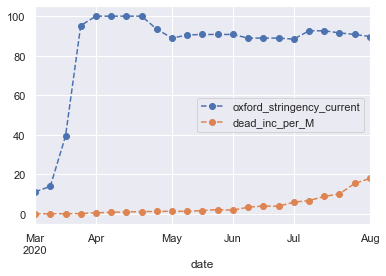

In [41]:

arg_weekly.plot(y=['oxford_stringency_current','dead_inc_per_M'],style='o--')

In [42]:
all_countries = pd.DataFrame()

for c in countries.groups:
    country = countries.get_group(c)
    inc = country['dead'] - country['dead'].shift()
    inc.name='inc'
    country = pd.concat([country,inc],axis=1)
    
    country = country.replace(np.inf,np.nan)
    country = country.dropna()
    all_countries = pd.concat([all_countries,country],axis=0)
    


In [43]:
all_countries.head(50)


,date,confirmed,dead,oxford_stringency_current,country,oxford_stringency_mean,pop,dead_per_M,abb,inc
158,2020-03-02,1.0,0.0,27.78,Afghanistan,72.993822,38928346,0.000000,AFG,0.0
164,2020-03-08,4.0,0.0,27.78,Afghanistan,72.993822,38928346,0.000000,AFG,0.0
167,2020-03-11,7.0,0.0,27.78,Afghanistan,72.993822,38928346,0.000000,AFG,0.0
171,2020-03-15,10.0,0.0,38.89,Afghanistan,72.993822,38928346,0.000000,AFG,0.0
172,2020-03-16,16.0,0.0,38.89,Afghanistan,72.993822,38928346,0.000000,AFG,0.0
173,2020-03-17,21.0,0.0,38.89,Afghanistan,72.993822,38928346,0.000000,AFG,0.0
174,2020-03-18,22.0,0.0,41.67,Afghanistan,72.993822,38928346,0.000000,AFG,0.0
175,2020-03-19,22.0,0.0,41.67,Afghanistan,72.993822,38928346,0.000000,AFG,0.0
176,2020-03-20,22.0,0.0,41.67,Afghanistan,72.993822,38928346,0.000000,AFG,0.0
177,2020-03-21,24.0,0.0,41.67,Afghanistan,72.993822,38928346,0.000000,AFG,0.0


In [44]:
select_countries = ['Sweden','UK','Spain','Italy','UK','Belgium','France','US','Germany']
select_countries = ['Sweden','UK','Belgium']

mask = all_countries['country'].isin(select_countries)

selected_countries = (all_countries[mask]).copy()
selected_countries

,date,confirmed,dead,oxford_stringency_current,country,oxford_stringency_mean,pop,dead_per_M,abb,inc
1830,2020-03-02,17.0,0.0,11.11,Belgium,63.049434,11589623,0.000000,BEL,0.0
1831,2020-03-03,37.0,0.0,11.11,Belgium,63.049434,11589623,0.000000,BEL,0.0
1832,2020-03-04,72.0,0.0,13.89,Belgium,63.049434,11589623,0.000000,BEL,0.0
1833,2020-03-05,126.0,0.0,13.89,Belgium,63.049434,11589623,0.000000,BEL,0.0
1834,2020-03-06,207.0,0.0,13.89,Belgium,63.049434,11589623,0.000000,BEL,0.0
...,...,...,...,...,...,...,...,...,...,...
9087,2020-07-31,302301.0,45999.0,64.35,UK,63.235096,67886011,677.591735,GBR,38.0
9088,2020-08-01,303181.0,46119.0,68.06,UK,63.235096,67886011,679.359404,GBR,120.0
9089,2020-08-02,303952.0,46193.0,68.06,UK,63.235096,67886011,680.449467,GBR,74.0
9090,2020-08-03,304695.0,46201.0,68.06,UK,63.235096,67886011,680.567312,GBR,8.0


In [45]:
unique_country_abbs = selected_countries['abb'].unique()
print (unique_country_abbs)
country_idx = dict(zip(unique_country_abbs,range(1,len(unique_country_abbs) + 1)))
country_idx    

['BEL' 'SWE' 'GBR']


{'BEL': 1, 'SWE': 2, 'GBR': 3}

In [46]:
unique_days = selected_countries['date'].unique()
day_idx = dict(zip(pd.to_datetime(unique_days),range(1,len(unique_days) + 1)))


In [47]:
def create_country_index(abb):
    return country_idx[abb]

def create_day_index(day):
    return day_idx[day]

selected_countries['country_idx'] = selected_countries['abb'].apply(create_country_index)
selected_countries['day_idx'] = selected_countries['date'].apply(create_day_index)
selected_countries['ox_idx'] = selected_countries['oxford_stringency_current'].astype(int)
selected_countries['inc_per_M'] = selected_countries['inc'] / (selected_countries['pop'] / 1e6)
selected_countries

,date,confirmed,dead,oxford_stringency_current,country,oxford_stringency_mean,pop,dead_per_M,abb,inc,country_idx,day_idx,ox_idx,inc_per_M
1830,2020-03-02,17.0,0.0,11.11,Belgium,63.049434,11589623,0.000000,BEL,0.0,1,1,11,0.000000
1831,2020-03-03,37.0,0.0,11.11,Belgium,63.049434,11589623,0.000000,BEL,0.0,1,2,11,0.000000
1832,2020-03-04,72.0,0.0,13.89,Belgium,63.049434,11589623,0.000000,BEL,0.0,1,3,13,0.000000
1833,2020-03-05,126.0,0.0,13.89,Belgium,63.049434,11589623,0.000000,BEL,0.0,1,4,13,0.000000
1834,2020-03-06,207.0,0.0,13.89,Belgium,63.049434,11589623,0.000000,BEL,0.0,1,5,13,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9087,2020-07-31,302301.0,45999.0,64.35,UK,63.235096,67886011,677.591735,GBR,38.0,3,152,64,0.559762
9088,2020-08-01,303181.0,46119.0,68.06,UK,63.235096,67886011,679.359404,GBR,120.0,3,153,68,1.767669
9089,2020-08-02,303952.0,46193.0,68.06,UK,63.235096,67886011,680.449467,GBR,74.0,3,154,68,1.090063
9090,2020-08-03,304695.0,46201.0,68.06,UK,63.235096,67886011,680.567312,GBR,8.0,3,155,68,0.117845


In [48]:
selected_countries.corr()

,confirmed,dead,oxford_stringency_current,oxford_stringency_mean,pop,dead_per_M,inc,country_idx,day_idx,ox_idx,inc_per_M
confirmed,1.000000,0.992844,0.433902,0.389597,0.705695,0.459595,0.241005,0.589938,0.532922,0.434630,-0.116445
dead,0.992844,1.000000,0.452715,0.447322,0.715547,0.454420,0.244629,0.566197,0.480850,0.454129,-0.106414
oxford_stringency_current,0.433902,0.452715,1.000000,0.570418,0.298656,0.389829,0.479226,0.001642,0.176835,0.999879,0.492127
oxford_stringency_mean,0.389597,0.447322,0.570418,1.000000,0.523436,0.298287,0.306930,0.002716,-0.005151,0.571678,0.104173
pop,0.705695,0.715547,0.298656,0.523436,1.000000,-0.064767,0.527783,0.853483,-0.010219,0.297717,-0.006857
dead_per_M,0.459595,0.454420,0.389829,0.298287,-0.064767,1.000000,-0.167972,-0.258443,0.842083,0.391990,-0.189576
inc,0.241005,0.244629,0.479226,0.306930,0.527783,-0.167972,1.000000,0.431697,-0.219848,0.474193,0.597933
country_idx,0.589938,0.566197,0.001642,0.002716,0.853483,-0.258443,0.431697,1.000000,-0.008843,-0.000231,-0.071759
day_idx,0.532922,0.480850,0.176835,-0.005151,-0.010219,0.842083,-0.219848,-0.008843,1.000000,0.177170,-0.325845
ox_idx,0.434630,0.454129,0.999879,0.571678,0.297717,0.391990,0.474193,-0.000231,0.177170,1.000000,0.490531


In [49]:
def logit_pure(x):
    return (np.exp(x)) / (1 + np.exp(x))

def logistic_pure(p):
    return np.log(p / (1 - p))

In [50]:
country_idx = selected_countries['country_idx']
day_idx = selected_countries['day_idx']
ox_idx = selected_countries['ox_idx']

x = selected_countries['oxford_stringency_mean']

r_alpha = pm.rnormal(0,1/1**2,10)
r_beta = pm.rnormal(0,1/1**2,10)

#[ logit_pure(r_alpha + r_beta * x) for x in selected_countries['oxford_stringency_current']]

In [51]:
#PYMC
import pymc as pm
from pymc.Matplot import plot as pmplot


x = np.log(selected_countries['oxford_stringency_current'])

alpha = pm.Normal('alpha',0, 1 / 1 ** 2,size=len(unique_country_abbs))

beta = pm.Normal('beta',0, 1/ 1 ** 2,size=len(unique_days))

@pm.deterministic
def logit(country_idx=country_idx-1,x=x,day_idx=day_idx-1,alpha=alpha,beta=beta):
        
    return np.exp(alpha[country_idx] + beta[day_idx]*x) / (
        1 + np.exp(alpha[country_idx] + beta[day_idx]*x) )


lkh = pm.Binomial('lkh',n=selected_countries['pop'],p=logit,observed=True,
                      value=selected_countries['inc'])

model = pm.Model([alpha,beta,logit,lkh])

_map = pm.MAP(model)
_map.fit()

mcmc = pm.MCMC(model)
sample = mcmc.sample(50000,20000,3)

/usr/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/lib/python3.6/site-packages/scipy/optimize/optimize.py:2613: RuntimeWarning: invalid value encountered in subtract
  if (fx2 - fval) > delta:


 [-----------------100%-----------------] 50000 of 50000 complete in 232.3 sec

Plotting alpha_0
Plotting alpha_1
Plotting alpha_2


,BEL,SWE,GBR
count,10000.000000,10000.000000,10000.000000
mean,-9.592439,-9.412102,-9.823290
std,0.041386,0.096593,0.040542
min,-9.672544,-9.529789,-9.882970
25%,-9.626476,-9.493480,-9.857717
50%,-9.604676,-9.438558,-9.836451
75%,-9.561934,-9.330389,-9.792427
max,-9.462019,-9.152162,-9.707134


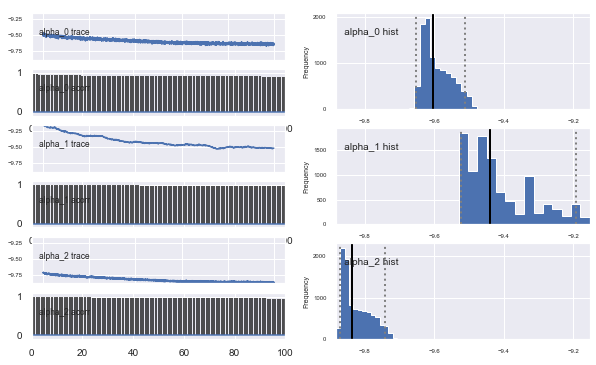

In [52]:
alpha = mcmc.trace('alpha')[:]
beta = mcmc.trace('beta')[:]

pmplot(alpha,'alpha')
#pmplot(beta,'beta')

result_alpha = pd.DataFrame(alpha,columns=unique_country_abbs)
result_beta = pd.DataFrame(beta)
result_beta.columns.name = 'day nr'

result_alpha.describe()

In [53]:
result_beta.describe()

day nr,0,1,2,3,4,5,6,7,8,9,...,148,149,150,151,152,153,154,155,156,157
count,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,6.362955e-04,5.920069e-04,6.142299e-04,6.645764e-04,1.258810e-04,0.001823,0.000966,-10.404111,-1.858341,-15.071584,...,-3.733268,-4.048413,-4.654202,-5.186005,-3.942521,-4.495306,-3.472002,-1.502786,-2.771180,-2.163043
std,9.475305e-04,8.447175e-04,8.626624e-04,9.831559e-04,4.114257e-07,0.000005,0.000004,0.038487,0.022182,0.020326,...,0.019194,0.024984,0.023239,0.027513,0.042450,0.033409,0.019427,0.023193,0.026066,0.032586
min,3.138057e-07,6.874487e-08,2.129132e-07,1.207560e-07,1.253935e-04,0.001807,0.000951,-10.453263,-1.952107,-15.141911,...,-3.789753,-4.111662,-4.744986,-5.275041,-4.040495,-4.573205,-3.515561,-1.546025,-2.856789,-2.271977
25%,1.134919e-04,1.189752e-04,1.098976e-04,1.071871e-04,1.256473e-04,0.001820,0.000965,-10.428848,-1.867797,-15.084544,...,-3.739860,-4.063559,-4.668787,-5.187940,-3.979825,-4.513692,-3.484654,-1.514826,-2.779317,-2.182725
50%,3.000386e-04,2.916478e-04,2.892863e-04,3.129803e-04,1.257905e-04,0.001823,0.000968,-10.424027,-1.855815,-15.067995,...,-3.735990,-4.050351,-4.647183,-5.174918,-3.921533,-4.491736,-3.478827,-1.504501,-2.757380,-2.147471
75%,7.468554e-04,7.122868e-04,7.149223e-04,7.607379e-04,1.259687e-04,0.001825,0.000969,-10.372799,-1.843372,-15.059564,...,-3.727369,-4.024326,-4.634905,-5.169858,-3.909479,-4.463247,-3.464560,-1.501333,-2.753158,-2.136054
max,1.216050e-02,8.587781e-03,6.575802e-03,7.624920e-03,1.274948e-04,0.001841,0.000976,-10.252630,-1.818873,-15.004389,...,-3.679096,-4.016016,-4.626858,-5.162022,-3.898521,-4.455209,-3.423479,-1.419245,-2.740234,-2.129671


In [54]:
swe_p = np.zeros((10000,146))
gbr_p = np.zeros((10000,146))
bel_p = np.zeros((10000,146))



for c in range(len(result_beta.columns)):
    
    swe_p[:,c] = logit_pure(result_alpha['SWE'].add(result_beta[c]))
    gbr_p[:,c] = logit_pure(result_alpha['GBR'].add(result_beta[c]))
    bel_p[:,c] = logit_pure(result_alpha['BEL'].add(result_beta[c]))
    
swe_p = pd.DataFrame(swe_p)
gbr_p = pd.DataFrame(gbr_p)
bel_p = pd.DataFrame(bel_p)

swe_p.describe()

IndexError: index 146 is out of bounds for axis 1 with size 146

In [ ]:
ax = swe_p.describe().loc['mean'].plot(color='yellow',figsize=(18,12))
gbr_p.describe().loc['mean'].plot(ax=ax,color='b')
bel_p.describe().loc['mean'].plot(ax=ax,color='r')